# Jupyter Notebook for RFR, SVR, and LSTM

# DATA 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Importing research data
prep0 = pd.read_csv('https://raw.githubusercontent.com/WisnuHanif/reactor_data/main/reactor_data.csv')
prep0.head()

,Time,Running_cycle,FI-001,FI-002,TC-001,TC-002,DT-001,DT-002,DP-001,DP-002,...,TI-034,TI-035,TI-036,TI-037,TI-038,TI-039,TI-040,TI-041,TI-042,CONVERSION
0,6/29/2004 4:00,1,57.376325,669.985139,319.496265,270.298088,68.159380,42.059748,16.935505,0.967330,...,308.465166,293.210571,288.108362,312.395056,305.310342,303.123348,310.085243,309.464836,308.546075,93.200705
1,6/29/2004 4:00,2,57.415584,670.175315,319.506829,270.557335,68.149101,43.819212,16.906026,0.974280,...,310.060319,294.679554,289.054518,314.409080,307.335927,304.765668,311.408695,310.634102,309.389468,93.128145
2,6/29/2004 4:00,3,57.454843,670.365491,319.517393,270.816583,68.138821,45.578677,16.876548,0.981229,...,311.655473,296.148536,290.000675,316.423104,309.361511,306.407989,312.732147,311.803369,310.232862,93.055586
3,6/30/2004 0:00,4,57.543094,670.622632,319.553869,271.363961,68.380253,49.568133,16.811533,1.000760,...,315.280320,299.371886,292.082630,320.951668,313.762146,309.971053,315.635902,314.406282,312.107740,92.830864
4,6/30/2004 0:00,5,57.470024,670.828064,319.515243,270.964477,67.735901,45.934814,16.879419,0.977966,...,312.047943,296.581512,290.251892,316.915100,309.949554,306.832458,313.039825,312.000702,310.427032,93.200151


In [3]:
#Identity variables name
prep0.columns

Index(['Time', 'Running_cycle', 'FI-001', 'FI-002', 'TC-001', 'TC-002',
       'DT-001', 'DT-002', 'DP-001', 'DP-002', 'DP-003', 'DP-004', 'PI-001',
       'PI-002', 'PI-003', 'PI-004', 'AI-001', 'AI-002', 'AI-003', 'AI-004',
       'AI-005', 'AI-006', 'AI-007', 'AI-008', 'AI-009', 'AI-010', 'RX-001',
       'TI-001', 'TI-002', 'TI-005', 'TI-006', 'TI-007', 'TI-008', 'TI-009',
       'TI-010', 'TI-011', 'TI-012', 'TI-013', 'TI-014', 'TI-015', 'TI-018',
       'TI-019', 'TI-020', 'TI-021', 'TI-022', 'TI-023', 'TI-024', 'TI-025',
       'TI-026', 'TI-027', 'TI-028', 'TI-029', 'TI-030', 'TI-031', 'TI-032',
       'TI-033', 'TI-034', 'TI-035', 'TI-036', 'TI-037', 'TI-038', 'TI-039',
       'TI-040', 'TI-041', 'TI-042', 'CONVERSION'],
      dtype='object')

# DATA PREPARATION, CLEANING, AND FEATURE EXTRACTION

In [4]:
#Removing unused column
prep1 = prep0.iloc[:, :].drop(['Running_cycle','Time', 'FI-001'], axis=1)
prep1

,FI-002,TC-001,TC-002,DT-001,DT-002,DP-001,DP-002,DP-003,DP-004,PI-001,...,TI-034,TI-035,TI-036,TI-037,TI-038,TI-039,TI-040,TI-041,TI-042,CONVERSION
0,669.985139,319.496265,270.298088,68.159380,42.059748,16.935505,0.967330,14.547414,32.450250,63.610362,...,308.465166,293.210571,288.108362,312.395056,305.310342,303.123348,310.085243,309.464836,308.546075,93.200705
1,670.175315,319.506829,270.557335,68.149101,43.819212,16.906026,0.974280,14.532135,32.412441,63.569363,...,310.060319,294.679554,289.054518,314.409080,307.335927,304.765668,311.408695,310.634102,309.389468,93.128145
2,670.365491,319.517393,270.816583,68.138821,45.578677,16.876548,0.981229,14.516856,32.374633,63.528364,...,311.655473,296.148536,290.000675,316.423104,309.361511,306.407989,312.732147,311.803369,310.232862,93.055586
3,670.622632,319.553869,271.363961,68.380253,49.568133,16.811533,1.000760,14.494793,32.307087,63.432052,...,315.280320,299.371886,292.082630,320.951668,313.762146,309.971053,315.635902,314.406282,312.107740,92.830864
4,670.828064,319.515243,270.964477,67.735901,45.934814,16.879419,0.977966,14.471894,32.329281,63.531145,...,312.047943,296.581512,290.251892,316.915100,309.949554,306.832458,313.039825,312.000702,310.427032,93.200151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18718,833.271973,323.390320,286.120880,67.911438,33.537292,20.344055,0.065580,20.184771,40.909565,70.437078,...,312.373871,301.223907,304.223450,299.636078,304.582642,300.072601,290.822022,289.512878,291.541504,94.829638
18719,832.827393,323.574768,286.037537,67.504608,33.254303,20.169985,0.066432,20.349388,40.900963,70.312330,...,312.328278,301.028229,304.057129,299.530151,304.531738,300.036346,290.642395,289.317627,291.300690,94.831773
18720,833.848450,323.598389,286.136810,67.682678,33.338257,20.028092,0.126205,20.386351,40.855808,70.336130,...,312.472900,301.012054,304.044495,299.594665,304.567383,300.047790,290.718109,289.436035,291.387756,94.878506
18721,833.529907,323.480347,286.043396,67.667175,32.947021,20.317225,0.075650,20.188131,40.896164,70.413744,...,312.350281,301.124390,304.156006,299.460388,304.473602,299.988190,290.674011,289.329468,291.345581,94.495033


In [5]:
#Convert timestamp object data to numerical
prep2 = prep1.apply(pd.to_numeric)
print(prep2.dtypes, prep2.shape)

FI-002        float64
TC-001        float64
TC-002        float64
DT-001        float64
DT-002        float64
               ...   
TI-039        float64
TI-040        float64
TI-041        float64
TI-042        float64
CONVERSION    float64
Length: 63, dtype: object (18723, 63)


In [6]:
#Check if there's missing value
prep2.isnull().sum()

FI-002        0
TC-001        0
TC-002        0
DT-001        0
DT-002        0
             ..
TI-039        0
TI-040        0
TI-041        0
TI-042        0
CONVERSION    0
Length: 63, dtype: int64

<AxesSubplot:xlabel='FI-002'>

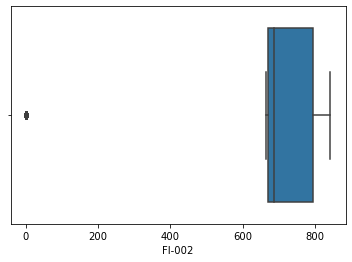

In [7]:
#Removing data where plant is not run, by identifying total raw material 'FI-001' loss flow rate
sns.boxplot(data=prep2,x=prep2['FI-002'])

In [8]:
#Remove shut down data by identifying outlier FI-001 with Inter Quantile Range Method

from numpy import percentile
# calculate interquartile range
q25_a, q75_a = percentile(prep2['FI-002'], 25), percentile(prep2['FI-002'], 75)
iqr_a = q75_a - q25_a
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25_a, q75_a, iqr_a))
# calculate the outlier cutoff
cut_off_a = iqr_a * 1.5
lower_a, upper_a = q25_a - cut_off_a, q75_a + cut_off_a
print('Lower whisker=%.2f, Upper whisker=%.2f' % (lower_a, upper_a))
# identify outliers
shut_down_data = prep2[(prep2['FI-002']<lower_a)|(prep2['FI-002']>upper_a)]
print('Shut down data: %d' % len(shut_down_data))
# remove outliers
shut_down_removed = prep2[(prep2['FI-002']>lower_a)&(prep2['FI-002']<upper_a)]
print('Non-Shut down data: %d' % len(shut_down_removed))

Percentiles: 25th=670.419, 75th=794.510, IQR=124.090
Lower whisker=484.28, Upper whisker=980.65
Shut down data: 2510
Non-Shut down data: 16213


<AxesSubplot:xlabel='FI-002'>

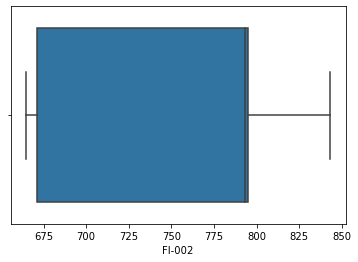

In [9]:
#Check again if there's still outlier in 'FI-001'
sns.boxplot(data=shut_down_removed, x=shut_down_removed['FI-002'])

In [10]:
prep3 = shut_down_removed
prep3.shape

(16213, 63)

In [11]:
#Remove outlier for all variables while keeps the whole row intact
lb = prep3.quantile(0.01)
ub = prep3.quantile(0.99)

prep4 = prep3[(prep3 > lb) & (prep3 < ub)]
prep4

,FI-002,TC-001,TC-002,DT-001,DT-002,DP-001,DP-002,DP-003,DP-004,PI-001,...,TI-034,TI-035,TI-036,TI-037,TI-038,TI-039,TI-040,TI-041,TI-042,CONVERSION
0,669.985139,319.496265,270.298088,68.159380,42.059748,16.935505,0.967330,14.547414,32.450250,63.610362,...,308.465166,293.210571,288.108362,312.395056,305.310342,303.123348,310.085243,309.464836,308.546075,93.200705
1,670.175315,319.506829,270.557335,68.149101,43.819212,16.906026,0.974280,14.532135,32.412441,63.569363,...,310.060319,294.679554,289.054518,314.409080,307.335927,304.765668,311.408695,310.634102,309.389468,93.128145
2,670.365491,319.517393,270.816583,68.138821,45.578677,16.876548,0.981229,14.516856,32.374633,63.528364,...,311.655473,296.148536,290.000675,316.423104,309.361511,306.407989,312.732147,311.803369,310.232862,93.055586
3,670.622632,319.553869,271.363961,68.380253,49.568133,16.811533,1.000760,14.494793,32.307087,63.432052,...,315.280320,299.371886,292.082630,320.951668,313.762146,309.971053,315.635902,314.406282,312.107740,92.830864
4,670.828064,319.515243,270.964477,67.735901,45.934814,16.879419,0.977966,14.471894,32.329281,63.531145,...,312.047943,296.581512,290.251892,316.915100,309.949554,306.832458,313.039825,312.000702,310.427032,93.200151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18718,833.271973,323.390320,286.120880,67.911438,33.537292,20.344055,0.065580,20.184771,40.909565,70.437078,...,312.373871,301.223907,304.223450,299.636078,304.582642,300.072601,290.822022,289.512878,291.541504,94.829638
18719,832.827393,323.574768,286.037537,67.504608,33.254303,20.169985,0.066432,20.349388,40.900963,70.312330,...,312.328278,301.028229,304.057129,299.530151,304.531738,300.036346,290.642395,289.317627,291.300690,94.831773
18720,833.848450,323.598389,286.136810,67.682678,33.338257,20.028092,0.126205,20.386351,40.855808,70.336130,...,312.472900,301.012054,304.044495,299.594665,304.567383,300.047790,290.718109,289.436035,291.387756,94.878506
18721,833.529907,323.480347,286.043396,67.667175,32.947021,20.317225,0.075650,20.188131,40.896164,70.413744,...,312.350281,301.124390,304.156006,299.460388,304.473602,299.988190,290.674011,289.329468,291.345581,94.495033


In [12]:
prep4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16213 entries, 0 to 18722
Data columns (total 63 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FI-002      15887 non-null  float64
 1   TC-001      15886 non-null  float64
 2   TC-002      15887 non-null  float64
 3   DT-001      15886 non-null  float64
 4   DT-002      15888 non-null  float64
 5   DP-001      15886 non-null  float64
 6   DP-002      15816 non-null  float64
 7   DP-003      15885 non-null  float64
 8   DP-004      15886 non-null  float64
 9   PI-001      15886 non-null  float64
 10  PI-002      15886 non-null  float64
 11  PI-003      15887 non-null  float64
 12  PI-004      15887 non-null  float64
 13  AI-001      15887 non-null  float64
 14  AI-002      15887 non-null  float64
 15  AI-003      15887 non-null  float64
 16  AI-004      15887 non-null  float64
 17  AI-005      15851 non-null  float64
 18  AI-006      15887 non-null  float64
 19  AI-007      15887 non-nul

<AxesSubplot:>

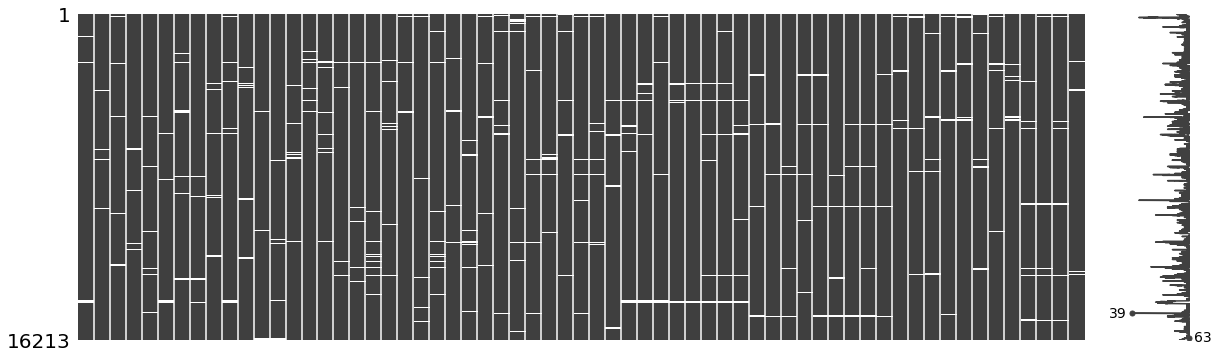

In [13]:
#Check deleted value position
import missingno as mno
mno.matrix(prep4, figsize = (20, 6))

In [14]:
#Fill missing value (from removed outlier) with imputer
prep5 = prep4.interpolate(method ='linear', limit_direction ='forward')
prep5.head()

,FI-002,TC-001,TC-002,DT-001,DT-002,DP-001,DP-002,DP-003,DP-004,PI-001,...,TI-034,TI-035,TI-036,TI-037,TI-038,TI-039,TI-040,TI-041,TI-042,CONVERSION
0,669.985139,319.496265,270.298088,68.159380,42.059748,16.935505,0.967330,14.547414,32.450250,63.610362,...,308.465166,293.210571,288.108362,312.395056,305.310342,303.123348,310.085243,309.464836,308.546075,93.200705
1,670.175315,319.506829,270.557335,68.149101,43.819212,16.906026,0.974280,14.532135,32.412441,63.569363,...,310.060319,294.679554,289.054518,314.409080,307.335927,304.765668,311.408695,310.634102,309.389468,93.128145
2,670.365491,319.517393,270.816583,68.138821,45.578677,16.876548,0.981229,14.516856,32.374633,63.528364,...,311.655473,296.148536,290.000675,316.423104,309.361511,306.407989,312.732147,311.803369,310.232862,93.055586
3,670.622632,319.553869,271.363961,68.380253,49.568133,16.811533,1.000760,14.494793,32.307087,63.432052,...,315.280320,299.371886,292.082630,320.951668,313.762146,309.971053,315.635902,314.406282,312.107740,92.830864
4,670.828064,319.515243,270.964477,67.735901,45.934814,16.879419,0.977966,14.471894,32.329281,63.531145,...,312.047943,296.581512,290.251892,316.915100,309.949554,306.832458,313.039825,312.000702,310.427032,93.200151


In [15]:
prep5.isnull().sum()

FI-002        0
TC-001        0
TC-002        0
DT-001        0
DT-002        0
             ..
TI-039        0
TI-040        0
TI-041        0
TI-042        0
CONVERSION    0
Length: 63, dtype: int64

In [16]:
prep5.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FI-002,16213.0,746.679192,68.974394,668.778687,671.182739,793.192139,794.781494,836.910889
TC-001,16213.0,322.950928,5.226784,312.015381,319.500427,322.585754,326.562042,334.638306
TC-002,16213.0,278.760113,6.484141,266.984192,273.608520,278.874756,284.130310,292.542786
DT-001,16213.0,66.416289,6.934921,51.402039,62.645111,67.749573,71.104828,80.546149
DT-002,16213.0,37.237985,11.090657,22.402069,28.286957,34.591809,43.110779,69.457214
...,...,...,...,...,...,...,...,...
TI-039,16213.0,304.102563,7.659816,288.000122,298.397888,304.587952,309.892517,320.615326
TI-040,16213.0,305.790454,14.960208,278.586883,291.905914,307.346619,316.723419,336.157837
TI-041,16213.0,307.477383,14.811054,281.091980,294.418945,307.079346,319.622864,336.463501
TI-042,16213.0,304.674310,16.186075,277.008789,290.616974,303.848419,318.172211,335.618439


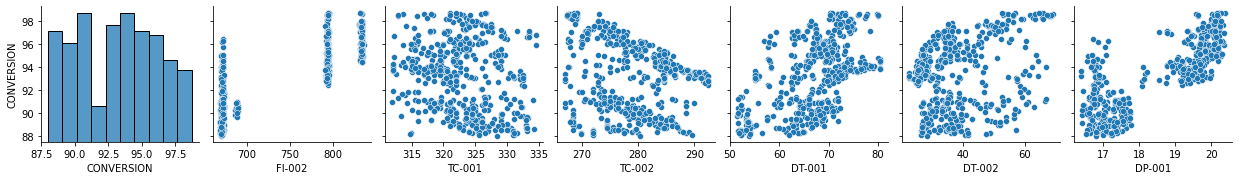

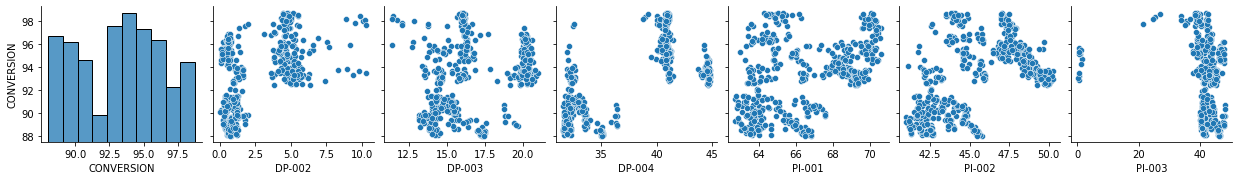

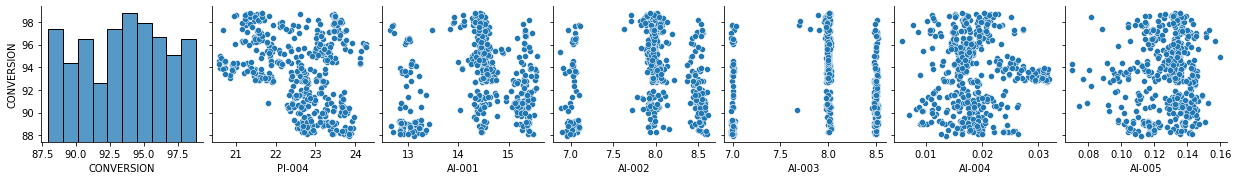

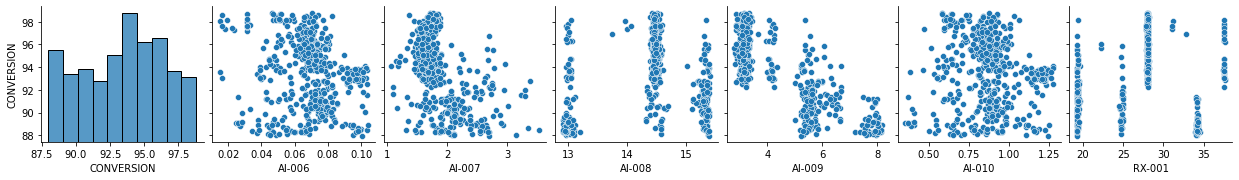

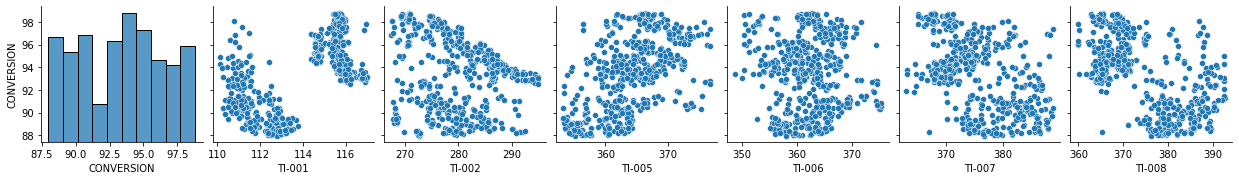

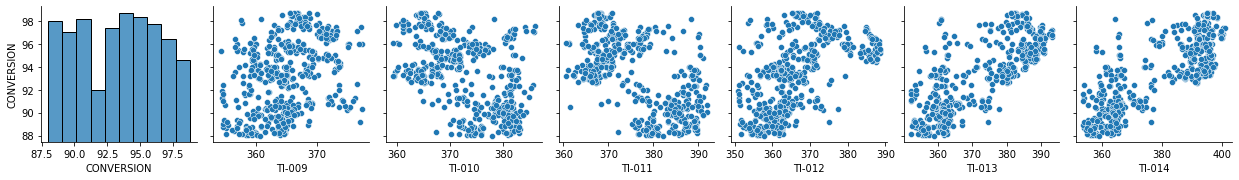

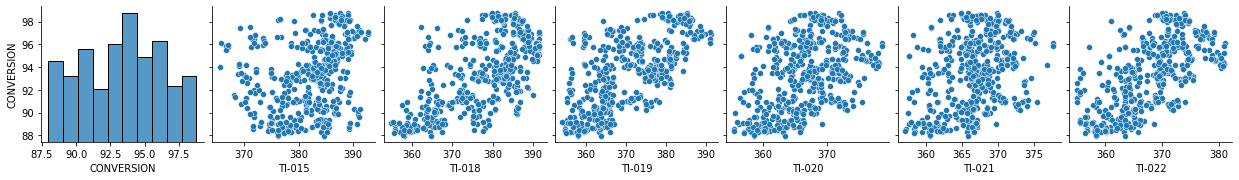

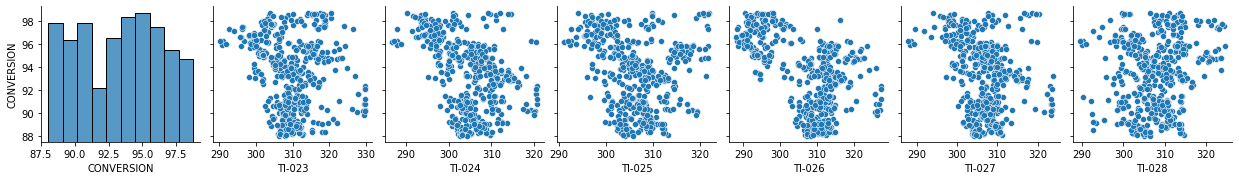

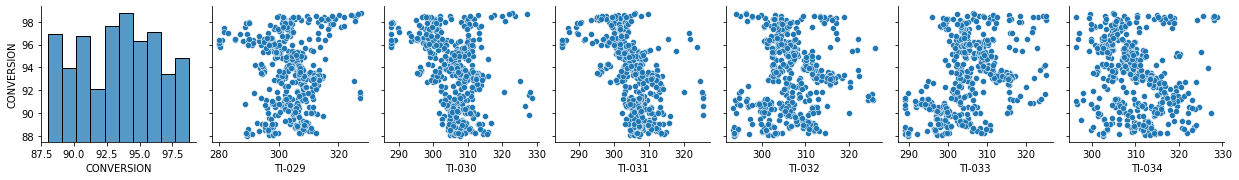

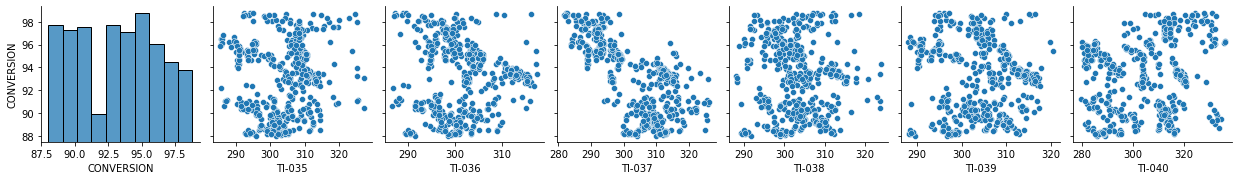

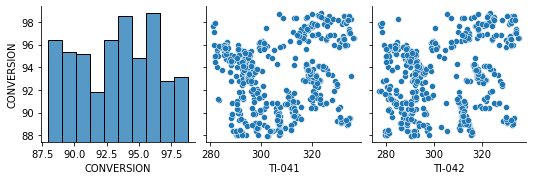

In [17]:
#Pairplot each predictor to target
sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION','FI-002', 'TC-001', 'TC-002','DT-001', 'DT-002','DP-001'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION','DP-002', 'DP-003', 'DP-004', 'PI-001','PI-002', 'PI-003'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION', 'PI-004', 'AI-001', 'AI-002','AI-003', 'AI-004','AI-005'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION', 'AI-006', 'AI-007','AI-008', 'AI-009', 'AI-010', 'RX-001'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION', 'TI-001','TI-002','TI-005', 'TI-006', 'TI-007', 'TI-008'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION','TI-009','TI-010', 'TI-011', 'TI-012', 'TI-013','TI-014'],
    y_vars = ['CONVERSION'])
    
sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION', 'TI-015', 'TI-018','TI-019', 'TI-020', 'TI-021', 'TI-022'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION','TI-023', 'TI-024', 'TI-025', 'TI-026', 'TI-027', 'TI-028'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION', 'TI-029', 'TI-030', 'TI-031', 'TI-032','TI-033', 'TI-034'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION','TI-035', 'TI-036', 'TI-037', 'TI-038', 'TI-039','TI-040'],
    y_vars = ['CONVERSION'])

sns.pairplot(prep5.sample(500),
    x_vars = ['CONVERSION','TI-041', 'TI-042'],
    y_vars = ['CONVERSION'])

In [18]:
#Correlation matrix after data imputation
corr2 = prep5.corr()
corr2.style.background_gradient(cmap='coolwarm')

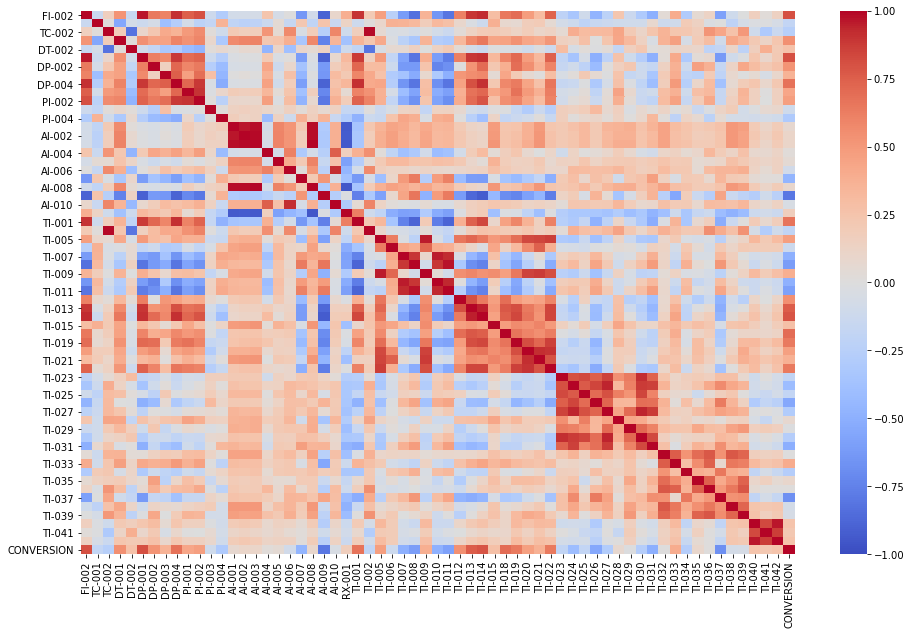

In [26]:
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(prep5.corr(), vmin=-1, vmax=1, cmap='coolwarm')
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [27]:
#Data Scaling with normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
scaled_data = pd.DataFrame(scaler.fit_transform(prep5), columns = prep5.columns)
print(scaled_data)

         FI-002    TC-001    TC-002    DT-001    DT-002    DP-001    DP-002  \
0      0.007176  0.330677  0.129659  0.574982  0.417758  0.137982  0.091838   
1      0.008307  0.331144  0.139802  0.574629  0.455150  0.130618  0.092498   
2      0.009438  0.331611  0.149945  0.574277  0.492541  0.123254  0.093158   
3      0.010967  0.333223  0.171362  0.582561  0.577324  0.107012  0.095012   
4      0.012189  0.331516  0.155732  0.560452  0.500110  0.123971  0.092848   
...         ...       ...       ...       ...       ...       ...       ...   
16208  0.978357  0.502806  0.748738  0.566475  0.236642  0.989480  0.006215   
16209  0.975713  0.510959  0.745477  0.552515  0.230628  0.945995  0.006296   
16210  0.981786  0.512003  0.749361  0.558625  0.232412  0.910548  0.011972   
16211  0.979891  0.506785  0.745706  0.558093  0.224098  0.982777  0.007171   
16212  0.979891  0.506785  0.745706  0.558093  0.224098  0.982777  0.007171   

         DP-003    DP-004    PI-001  ...    TI-034 

In [28]:
# Pearson correlation coefficient
select_corr = scaled_data.corr()["CONVERSION"].sort_values(ascending=False)[1:]

# absolute for positive values
abs_corr = abs(select_corr)

# random threshold for features to keep
selected_features = abs_corr[abs_corr>0.4]
selected_features

DP-001    0.807746
FI-002    0.806157
TI-014    0.795037
TI-013    0.764606
TI-018    0.700174
DP-004    0.675512
TI-001    0.667385
TI-019    0.647600
TI-022    0.644449
DT-001    0.544135
TI-012    0.542178
DP-002    0.530594
PI-002    0.473997
TI-005    0.472168
TI-020    0.465437
PI-001    0.430794
TI-024    0.408135
AI-007    0.462468
TI-010    0.487901
TI-007    0.495802
TI-031    0.504460
TI-026    0.542696
TI-011    0.582506
TI-008    0.608041
TI-037    0.676970
AI-009    0.797870
Name: CONVERSION, dtype: float64

In [29]:
len(selected_features)

26

In [30]:
# Drop low correlation features
prep6 = scaled_data[selected_features.index].interpolate(method ='linear', limit_direction ='backward')
prep6.isnull().sum()

DP-001    0
FI-002    0
TI-014    0
TI-013    0
TI-018    0
DP-004    0
TI-001    0
TI-019    0
TI-022    0
DT-001    0
TI-012    0
DP-002    0
PI-002    0
TI-005    0
TI-020    0
PI-001    0
TI-024    0
AI-007    0
TI-010    0
TI-007    0
TI-031    0
TI-026    0
TI-011    0
TI-008    0
TI-037    0
AI-009    0
dtype: int64

In [31]:
y_lasso = scaled_data["CONVERSION"]
X_lasso = prep6

In [32]:
#Eliminate multicollinearity by removing irrelavant features with ebbedded method
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_lasso, y_lasso)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_lasso,y_lasso))
coef = pd.Series(reg.coef_, index = X_lasso.columns)

Best alpha using built-in LassoCV: 0.000093
Best score using built-in LassoCV: 0.933171


In [33]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 23 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

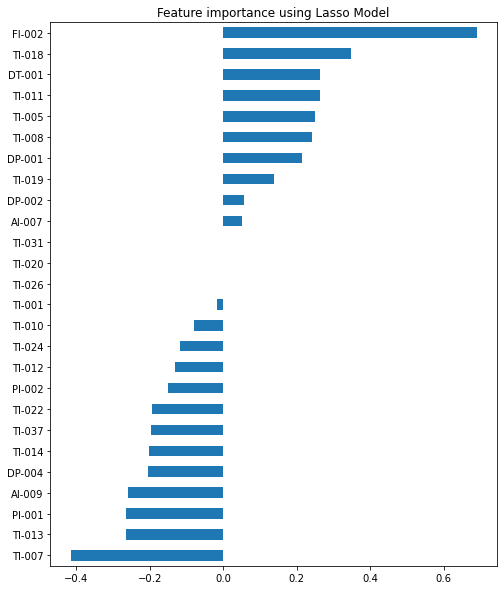

In [34]:
#Visualize important feature
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [35]:
#Select relevant reatures
abs_coef = abs(coef)
relevant_features = abs_coef[abs_coef>0]
prep7 = prep6[relevant_features.index].sort_index(axis=1, ascending=True)
prep7['CONVERSION'] = scaled_data["CONVERSION"]
prep7.shape

(16213, 24)

In [36]:
#Showing correlation between relevant features
corr3 = prep7.corr().style.background_gradient(cmap='coolwarm')
corr3

,AI-007,AI-009,DP-001,DP-002,DP-004,DT-001,FI-002,PI-001,PI-002,TI-001,TI-005,TI-007,TI-008,TI-010,TI-011,TI-012,TI-013,TI-014,TI-018,TI-019,TI-022,TI-024,TI-037,CONVERSION
AI-007,1.000000,0.508171,-0.605068,-0.365598,-0.598543,-0.329122,-0.633123,-0.380027,-0.473995,-0.630089,-0.390715,0.496358,0.633507,0.485211,0.611309,-0.421666,-0.604346,-0.610053,-0.352382,-0.425173,-0.502453,0.286689,0.343341,-0.462468
AI-009,0.508171,1.000000,-0.899661,-0.620813,-0.894308,-0.743551,-0.895437,-0.711594,-0.792831,-0.752550,-0.576772,0.441013,0.658815,0.488060,0.633110,-0.616926,-0.874695,-0.924246,-0.692661,-0.730534,-0.771141,0.188240,0.437556,-0.797870
DP-001,-0.605068,-0.899661,1.000000,0.620755,0.889258,0.539755,0.965602,0.706694,0.738625,0.881947,0.492134,-0.567006,-0.808451,-0.608148,-0.773423,0.621358,0.891708,0.913155,0.601093,0.716365,0.745159,-0.354156,-0.621459,0.807746
DP-002,-0.365598,-0.620813,0.620755,1.000000,0.722134,0.456555,0.640760,0.588011,0.645439,0.725394,0.308169,-0.622378,-0.619462,-0.727030,-0.678629,0.003394,0.527995,0.707311,0.388921,0.694828,0.599367,-0.100517,-0.166654,0.530594
DP-004,-0.598543,-0.894308,0.889258,0.722134,1.000000,0.607239,0.909023,0.723330,0.883843,0.913648,0.429869,-0.648597,-0.812200,-0.677713,-0.811741,0.460695,0.808411,0.907286,0.585408,0.640425,0.660184,-0.140233,-0.374423,0.675512
DT-001,-0.329122,-0.743551,0.539755,0.456555,0.607239,1.000000,0.530917,0.536242,0.590392,0.355050,0.414796,-0.220331,-0.330181,-0.271744,-0.304564,0.334746,0.570736,0.655155,0.457136,0.534459,0.512240,0.131472,-0.095858,0.544135
FI-002,-0.633123,-0.895437,0.965602,0.640760,0.909023,0.530917,1.000000,0.757240,0.810297,0.901855,0.474443,-0.613811,-0.828346,-0.644734,-0.809575,0.611593,0.894242,0.928547,0.648715,0.696366,0.735951,-0.336182,-0.585382,0.806157
PI-001,-0.380027,-0.711594,0.706694,0.588011,0.723330,0.536242,0.757240,1.000000,0.900401,0.608901,0.371899,-0.400631,-0.563919,-0.509155,-0.587717,0.382584,0.675045,0.723003,0.503509,0.677317,0.632747,-0.043757,-0.161847,0.430794
PI-002,-0.473995,-0.792831,0.738625,0.645439,0.883843,0.590392,0.810297,0.900401,1.000000,0.741510,0.375364,-0.515149,-0.664529,-0.577960,-0.686526,0.399252,0.704911,0.794443,0.552277,0.600037,0.604474,0.015895,-0.156943,0.473997
TI-001,-0.630089,-0.752550,0.881947,0.725394,0.913648,0.355050,0.901855,0.608901,0.741510,1.000000,0.329103,-0.746413,-0.887895,-0.769282,-0.890285,0.376772,0.746975,0.837916,0.458846,0.591936,0.610212,-0.310427,-0.511568,0.667385


In [37]:
#Drop high correlation variables among predictor
prep8 = prep7.drop(['FI-002', 'TI-001','TI-007', 'TI-010', 'TI-011', 'TI-014', 'PI-001'], axis = 1)

In [38]:
#Showing correlation between relevant features
corr4 = prep8.corr().style.background_gradient(cmap='coolwarm')
corr4

,AI-007,AI-009,DP-001,DP-002,DP-004,DT-001,PI-002,TI-005,TI-008,TI-012,TI-013,TI-018,TI-019,TI-022,TI-024,TI-037,CONVERSION
AI-007,1.000000,0.508171,-0.605068,-0.365598,-0.598543,-0.329122,-0.473995,-0.390715,0.633507,-0.421666,-0.604346,-0.352382,-0.425173,-0.502453,0.286689,0.343341,-0.462468
AI-009,0.508171,1.000000,-0.899661,-0.620813,-0.894308,-0.743551,-0.792831,-0.576772,0.658815,-0.616926,-0.874695,-0.692661,-0.730534,-0.771141,0.188240,0.437556,-0.797870
DP-001,-0.605068,-0.899661,1.000000,0.620755,0.889258,0.539755,0.738625,0.492134,-0.808451,0.621358,0.891708,0.601093,0.716365,0.745159,-0.354156,-0.621459,0.807746
DP-002,-0.365598,-0.620813,0.620755,1.000000,0.722134,0.456555,0.645439,0.308169,-0.619462,0.003394,0.527995,0.388921,0.694828,0.599367,-0.100517,-0.166654,0.530594
DP-004,-0.598543,-0.894308,0.889258,0.722134,1.000000,0.607239,0.883843,0.429869,-0.812200,0.460695,0.808411,0.585408,0.640425,0.660184,-0.140233,-0.374423,0.675512
DT-001,-0.329122,-0.743551,0.539755,0.456555,0.607239,1.000000,0.590392,0.414796,-0.330181,0.334746,0.570736,0.457136,0.534459,0.512240,0.131472,-0.095858,0.544135
PI-002,-0.473995,-0.792831,0.738625,0.645439,0.883843,0.590392,1.000000,0.375364,-0.664529,0.399252,0.704911,0.552277,0.600037,0.604474,0.015895,-0.156943,0.473997
TI-005,-0.390715,-0.576772,0.492134,0.308169,0.429869,0.414796,0.375364,1.000000,-0.223338,0.663101,0.721532,0.567874,0.692503,0.869386,-0.326888,-0.236536,0.471386
TI-008,0.633507,0.658815,-0.808451,-0.619462,-0.812200,-0.330181,-0.664529,-0.223338,1.000000,-0.324047,-0.680916,-0.363761,-0.555022,-0.518661,0.317664,0.509761,-0.608041
TI-012,-0.421666,-0.616926,0.621358,0.003394,0.460695,0.334746,0.399252,0.663101,-0.324047,1.000000,0.807006,0.691695,0.480650,0.593642,-0.248633,-0.468822,0.542178


In [39]:
# Pearson correlation coefficient
corr_final_feat = prep8.corr()["CONVERSION"].sort_values(ascending=False)[1:]

# absolute for positive values
abs_corr_final = abs(corr_final_feat)

print(abs_corr_final)

DP-001    0.807746
TI-013    0.764606
TI-018    0.700174
DP-004    0.675512
TI-019    0.647600
TI-022    0.644449
DT-001    0.544135
TI-012    0.542178
DP-002    0.530594
PI-002    0.473997
TI-005    0.471386
TI-024    0.408135
AI-007    0.462468
TI-008    0.608041
TI-037    0.676970
AI-009    0.797870
Name: CONVERSION, dtype: float64


In [40]:
prep8.describe()

,AI-007,AI-009,DP-001,DP-002,DP-004,DT-001,PI-002,TI-005,TI-008,TI-012,TI-013,TI-018,TI-019,TI-022,TI-024,TI-037,CONVERSION
count,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000
mean,0.344613,0.346348,0.530719,0.244814,0.464081,0.515173,0.440587,0.472970,0.448470,0.406076,0.503894,0.607074,0.444170,0.495458,0.521960,0.482083,0.491219
std,0.161072,0.311541,0.344385,0.215015,0.365870,0.237953,0.284654,0.220095,0.268006,0.240323,0.292610,0.270313,0.253621,0.233386,0.191360,0.242921,0.281156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240180,0.074240,0.159918,0.058720,0.055099,0.385775,0.176755,0.334918,0.201664,0.241212,0.227581,0.377764,0.250587,0.324455,0.409749,0.262745,0.235998
50%,0.290550,0.244595,0.692077,0.117396,0.676352,0.560921,0.385582,0.459779,0.359732,0.354211,0.550594,0.692458,0.409205,0.509707,0.533446,0.510281,0.510707
75%,0.415732,0.544039,0.853240,0.452093,0.713119,0.676047,0.700792,0.616159,0.681762,0.533615,0.760995,0.810577,0.640118,0.651880,0.655715,0.680016,0.717906
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
prep8.columns

Index(['AI-007', 'AI-009', 'DP-001', 'DP-002', 'DP-004', 'DT-001', 'PI-002',
       'TI-005', 'TI-008', 'TI-012', 'TI-013', 'TI-018', 'TI-019', 'TI-022',
       'TI-024', 'TI-037', 'CONVERSION'],
      dtype='object')

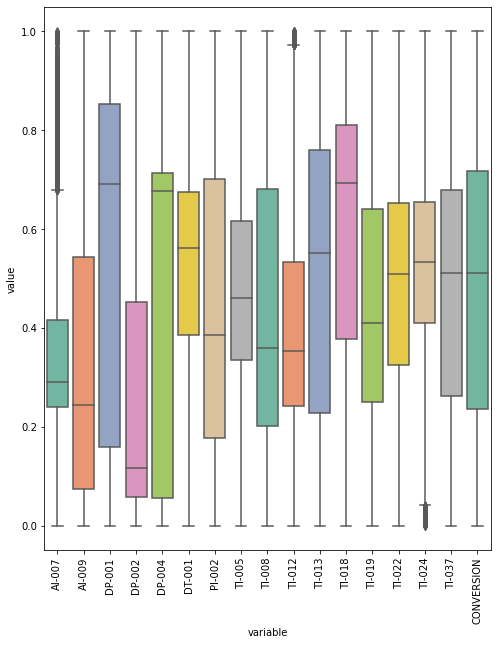

In [42]:
all_boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame(data=scaled_data, 
        columns=['AI-007', 'AI-009', 'DP-001', 'DP-002', 'DP-004', 'DT-001',
       'PI-002', 'TI-005', 'TI-008', 'TI-012', 'TI-013', 'TI-018', 'TI-019',
       'TI-022', 'TI-024', 'TI-037', 'CONVERSION'])), linewidth=1.5, palette="Set2")
plt.setp(all_boxplot.get_xticklabels(), rotation=90)
plt.show()

In [43]:
len(prep8.columns)

17

In [44]:
#Select data for predictors and target

#Import the features
X_df = prep8.drop('CONVERSION', axis = 1)
X = prep8.drop('CONVERSION', axis = 1).values.astype(float).reshape(-1, len(prep8.columns)-1)

# Extract the target
y_df = prep8['CONVERSION']
y = prep8['CONVERSION'].values.astype(float)

print(X.shape, y.shape)

(16213, 16) (16213,)


In [45]:
#Create function to return conversion scale for later use
def return_conversion_scale(variable_plot):
    minimum = min(prep5['CONVERSION'])
    maximum = max(prep5['CONVERSION'])
    return ((variable_plot - min(variable_plot)) /(max(variable_plot) - min(variable_plot)))*(maximum-minimum)+minimum

In [53]:
#Divide data into training 70%, validation 15% and testing 15%
#In this first step, we will divide data which will be used to train the model and as prediction
#1st splitting : training (85%); testing (15%)
y_tr_size = int(len(y) * 0.85)
y_tr, y_test = y[0:y_tr_size], y[y_tr_size:len(y)]
X_tr_size = int(len(X) * 0.85)
X_tr, X_test = X[0:X_tr_size], X[X_tr_size:len(X)]
print('Observations: %d' % (len(y)))
print('Training Observations: %d' % (len(y_tr)))
print('Testing Observations: %d' % (len(y_test)))

Observations: 16213
Training Observations: 13781
Testing Observations: 2432


In [54]:
print('Training Features Shape:', X_tr.shape)
print('Training Targets Shape:', X_test.shape)
print('Testing Features Shape:', y_tr.shape)
print('Testing Targets Shape:', y_test.shape)

Training Features Shape: (13781, 16)
Training Targets Shape: (2432, 16)
Testing Features Shape: (13781,)
Testing Targets Shape: (2432,)


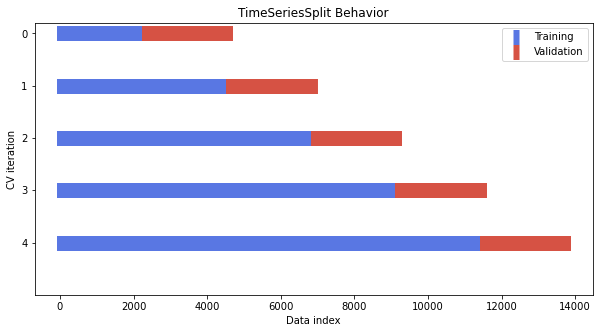

In [55]:
#Import and initialize the cross-validation iterator
#In the second step, we split training data from 1st step into training (80%); validation (20%)
from sklearn.model_selection import TimeSeriesSplit

n_splits = 5
ts_split = TimeSeriesSplit(n_splits)

fig, ax = plt.subplots(figsize=(10,5))
for ii, (tr, tt) in enumerate(ts_split.split(X_tr, y_tr)):
    
    #Plot training and testing indices
    l1 = ax.scatter(tr, [ii] * len(tr), c=[plt.cm.coolwarm(.1)],
                    marker='_', lw=15)
    l2 = ax.scatter(tt, [ii] * len(tt), c=[plt.cm.coolwarm(.9)],
                    marker='_', lw=15)
    ax.set(ylim=[n_splits, -.2], yticks=np.arange(n_splits), title='TimeSeriesSplit Behavior', xlabel='Data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [56]:
for train_index, test_index in ts_split.split(X_tr, y_tr):
     print("TRAIN:", train_index, "TEST:", test_index)

     #To get the indices 
     X_train, X_val = X_tr[train_index], X_tr[test_index]
     y_train, y_val = y_tr[train_index], y_tr[test_index]

TRAIN: [   0    1    2 ... 2298 2299 2300] TEST: [2301 2302 2303 ... 4594 4595 4596]
TRAIN: [   0    1    2 ... 4594 4595 4596] TEST: [4597 4598 4599 ... 6890 6891 6892]
TRAIN: [   0    1    2 ... 6890 6891 6892] TEST: [6893 6894 6895 ... 9186 9187 9188]
TRAIN: [   0    1    2 ... 9186 9187 9188] TEST: [ 9189  9190  9191 ... 11482 11483 11484]
TRAIN: [    0     1     2 ... 11482 11483 11484] TEST: [11485 11486 11487 ... 13778 13779 13780]


In [57]:
print('Training Features Shape:', X_train.shape)
print('Training Targets Shape:', y_train.shape)
print('Validation Features Shape:', X_val.shape)
print('Validation Targets Shape:', y_val.shape)

Training Features Shape: (11485, 16)
Training Targets Shape: (11485,)
Validation Features Shape: (2296, 16)
Validation Targets Shape: (2296,)


In [58]:
#Measurement metrics for inverted scale
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score 
from sklearn.linear_model import LinearRegression
from math import log
    
def model_metrics(actual, predict):
    ac = return_conversion_scale(actual)
    pr = return_conversion_scale(predict)
    print('Mean Absolute Error:', metrics.mean_absolute_error(ac, pr))
    print('Mean Squared Error:', metrics.mean_squared_error(ac, pr))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ac, pr)))
    print('Coefficient of Determination:', r2_score(actual, predict)) 
    
    # calculate aic for regression
    lr_model = LinearRegression()
    lr_model.fit(pr.reshape(-1, 1), ac.reshape(-1, 1))
    # number of parameters
    num_params = len(lr_model.coef_) + 1
    # predict the training set
    yhat = lr_model.predict(pr.reshape(-1, 1))
    # calculate the error
    mse = metrics.mean_squared_error(ac, yhat)
    # calculate the aic
    aic = len(ac) * log(mse) + 2 * num_params
    print('Akaike Information Criterion: %.3f' % aic)
    
    # calculate bic for regression
    bic = len(ac) * log(mse) + num_params * log(len(ac))
    print('Bayesian Information Criterion: %.3f' % bic)

# MACHINE LEARNING MODEL : RANDOM FORREST REGRESSION

In [60]:
feature_list = list(X_df.columns)
feature_names = X_df.columns

In [61]:
#Run Ramdom Forest Regressor without hyper parameter tuning (default)
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, oob_score = True)
regressor.fit(X_train, y_train) 

RandomForestRegressor(oob_score=True)

In [62]:
regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [63]:
#Generate Regressor score and OOB Score of the model
print("\nRegressor Score " + str(regressor.score(X_train, y_train)), "\nOOB Score " + str(regressor.oob_score_))


Regressor Score 0.9980444795115136 
OOB Score 0.9857566503040474


In [64]:
rfr_model_pred = regressor.predict(X_val)
rfr_model_pred

array([0.47620999, 0.52923038, 0.57139988, ..., 0.84455007, 0.84432811,
       0.8337795 ])

In [65]:
# evaluate predictions for base model
model_metrics(y_val, rfr_model_pred)

Mean Absolute Error: 0.6370248734136283
Mean Squared Error: 1.3902709274983964
Root Mean Squared Error: 1.1790975055093604
Coefficient of Determination: 0.9085108407420159
Akaike Information Criterion: 509.549
Bayesian Information Criterion: 521.026


<Figure size 640x480 with 0 Axes>

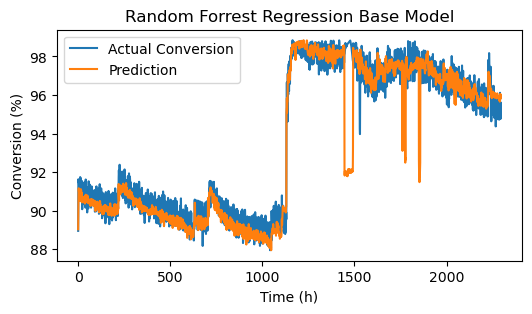

In [66]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_val), label = "Actual Conversion")
    plt.plot(return_conversion_scale(rfr_model_pred), label = "Prediction")
    #plt.grid()
    plt.title('Random Forrest Regression Base Model')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

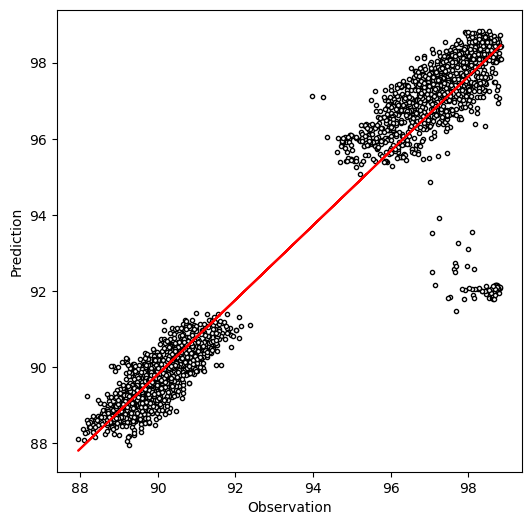

In [67]:
#Plot relationship between observed and predicted value
m_rfr_train, b_rfr_train = np.polyfit(return_conversion_scale(y_val), return_conversion_scale(rfr_model_pred), 1)
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_val), return_conversion_scale(rfr_model_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_val), m_rfr_train*(return_conversion_scale(y_val)) + b_rfr_train, color = 'r')
    #plt.grid()
    #plt.title('Random Forrest Regression Base Model')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [68]:
#Showing feature importance based on random forrest
fi = pd.DataFrame({'feature': feature_list,
                   'importance': regressor.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
2,DP-001,0.609129
11,TI-018,0.110117
15,TI-037,0.106830
5,DT-001,0.037784
1,AI-009,0.028156
3,DP-002,0.023206
14,TI-024,0.018714
6,PI-002,0.015418
9,TI-012,0.013821
8,TI-008,0.008908


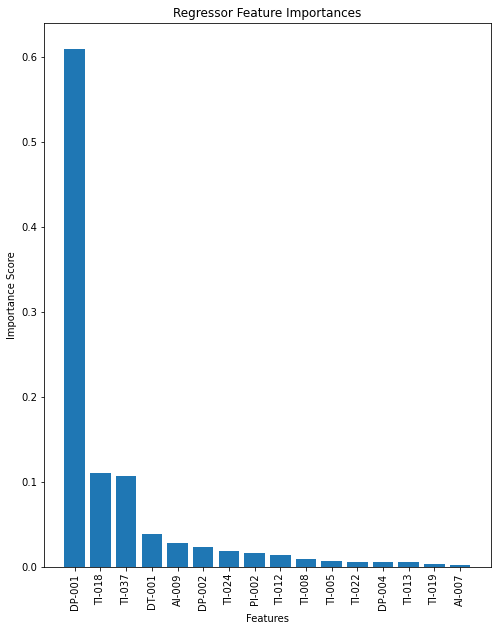

In [69]:
#plt.subplots(figsize=(10,4))
plt.bar(fi['feature'], fi['importance'])
plt.title('Regressor Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation = 90)
plt.show()

In [70]:
#Random Search with Cross Validation
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 39)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 200, scoring='neg_mean_squared_error', 
                              cv = ts_split, verbose=2, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
print(rf_random.best_params_)

In [ ]:
print(rf_random.best_estimator_)

In [72]:
#RFR_final = rf_random.best_estimator_
RFR_final = RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=8, n_estimators=80).fit(X_train, y_train)
val_pred = RFR_final.predict(X_val)
val_pred

array([0.47501523, 0.56967496, 0.57135466, ..., 0.83219283, 0.82930294,
       0.82233191])

In [73]:
#Evaluate the Best Random Search Model

model_metrics(y_val, val_pred)

Mean Absolute Error: 0.5759522620811224
Mean Squared Error: 0.6997532131110814
Root Mean Squared Error: 0.8365125301578461
Coefficient of Determination: 0.9557630931381305
Akaike Information Criterion: -1156.849
Bayesian Information Criterion: -1145.371


<Figure size 640x480 with 0 Axes>

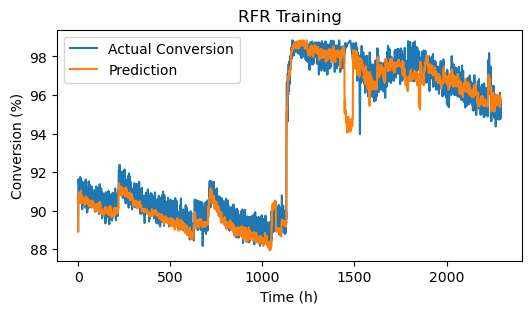

In [75]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_val), label = "Actual Conversion")
    plt.plot(return_conversion_scale(val_pred), label = "Prediction")
    #plt.grid()
    plt.title('RFR Training')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

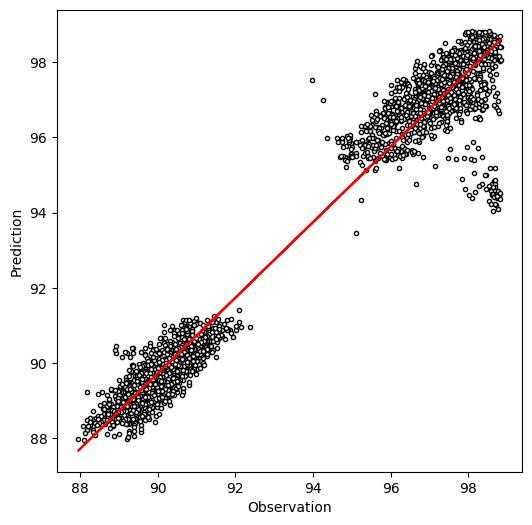

In [76]:
#Plot relationship between observed and predicted value
m_rfr_tr, b_rfr_tr = np.polyfit(return_conversion_scale(y_val), return_conversion_scale(val_pred), 1)
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_val), return_conversion_scale(val_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_val), m_rfr_tr*(return_conversion_scale(y_val)) + b_rfr_tr, color = 'r')
    #plt.grid()
    #plt.title('Random Forrest Regression Base Model')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [77]:
#Predict testing data
RFR_predict = RFR_final.predict(X_test)

In [78]:
#measure model performance
model_metrics(y_test, RFR_predict)

Mean Absolute Error: 0.8012519529657375
Mean Squared Error: 1.0096194029705026
Root Mean Squared Error: 1.0047981901707936
Coefficient of Determination: 0.8405333929383628
Akaike Information Criterion: -974.669
Bayesian Information Criterion: -963.076


<Figure size 640x480 with 0 Axes>

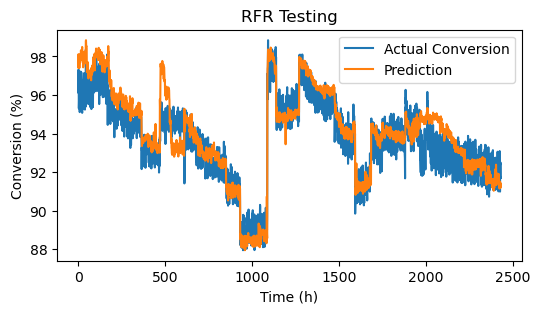

In [79]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_test), label = "Actual Conversion")
    plt.plot(return_conversion_scale(RFR_predict), label = "Prediction")
    #plt.grid()
    plt.title('RFR Testing')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

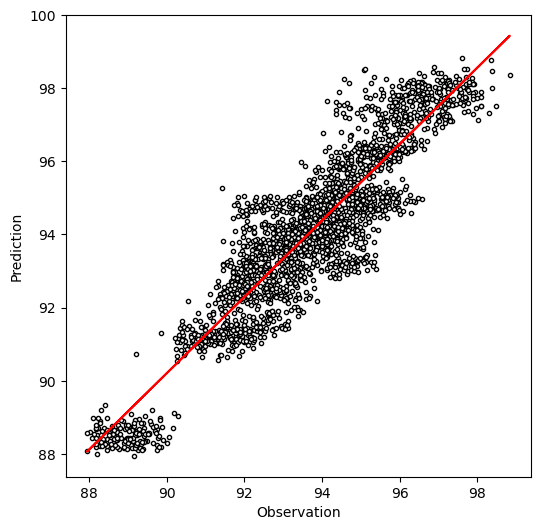

In [80]:
#Plot relationship between observed and predicted value
m_rfr_test, b_rfr_test = np.polyfit(return_conversion_scale(y_test), return_conversion_scale(RFR_predict), 1)
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_test), return_conversion_scale(RFR_predict), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_test), m_rfr_test*(return_conversion_scale(y_test)) + b_rfr_test, color = 'r')
    #plt.grid()
    #plt.title('Random Forrest Regression Base Model')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

# MACHINE LEARNING MODEL : SUPPORT VECTOR REGRESSION

In [81]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#Fit SVR base model
svr_rbf = SVR()
svr_rbf.fit(X_train, y_train)

SVR()

In [82]:
svr_rbf.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [83]:
#Predict SVR base model
svr_pred = svr_rbf.predict(X_val)
svr_pred

array([0.515374  , 0.57835173, 0.60861518, ..., 0.79691973, 0.79603819,
       0.79677832])

In [84]:
#Evaluating SVR performance
model_metrics(y_val, svr_pred)

Mean Absolute Error: 0.6506031191950616
Mean Squared Error: 0.663264386662157
Root Mean Squared Error: 0.8144104534337443
Coefficient of Determination: 0.9430675451877873
Akaike Information Criterion: -1278.111
Bayesian Information Criterion: -1266.634


<Figure size 640x480 with 0 Axes>

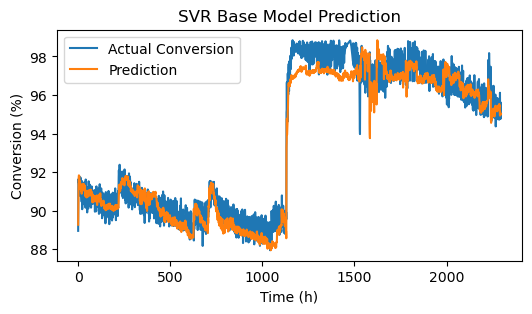

In [85]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_val), label = "Actual Conversion")
    plt.plot(return_conversion_scale(svr_pred), label = "Prediction")
    #plt.grid()
    plt.title('SVR Base Model Prediction')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

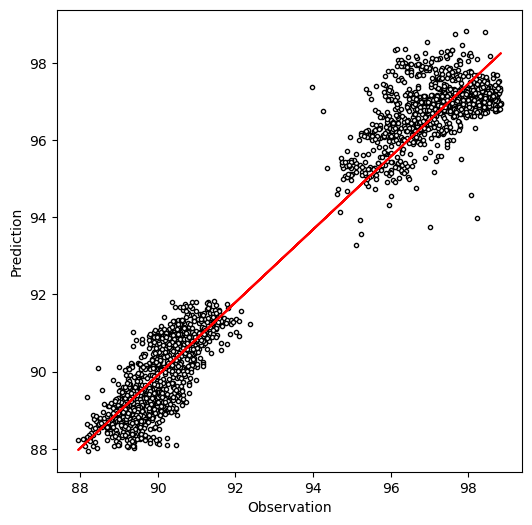

In [86]:
#Plot relationship between observed and predicted value
m_svr_base, b_svr_base = np.polyfit(return_conversion_scale(y_val), return_conversion_scale(svr_pred), 1)
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_val), return_conversion_scale(svr_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_val), m_svr_base*(return_conversion_scale(y_val)) + b_svr_base, color = 'r')
    #plt.grid()
    #plt.title('Random Forrest Regression Base Model')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [103]:
#Set parameter for grid search :
kernel = ['poly', 'rbf']
gamma = ['scale', 'auto']
degree = [1, 2, 3, 4]
C = [0.01, 0.1, 1, 10] 
epsilon = [0.01, 0.1, 1]

# Create the random grid
param_grid = {'C': C,
              'kernel': kernel,
              'degree': degree,
              'gamma': gamma,
               'epsilon': epsilon}

print(param_grid)

{'C': [0.01, 0.1, 1, 10], 'kernel': ['poly', 'rbf'], 'degree': [1, 2, 3, 4], 'gamma': ['scale', 'auto'], 'epsilon': [0.01, 0.1, 1]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

svr_random = RandomizedSearchCV(estimator=SVR(), param_distributions=param_grid,
                              n_iter = 100, verbose = 3, n_jobs=-1, cv = ts_split,
                                scoring = 'neg_mean_squared_error')
svr_random.fit(X_train, y_train)

In [ ]:
svr_random.best_params_

In [ ]:
#Use the random grid to search for best hyperparameters

# Create the grid search model and fit to the training data
svr_grid = GridSearchCV(SVR(), param_grid=param_grid, verbose = 3, n_jobs=-1, cv = ts_split,
                                scoring = 'neg_mean_squared_error')
svr_grid.fit(X_train, y_train)

In [123]:
#svr_final = svr_grid.best_params_
svr_final = SVR(C = 1, epsilon= 0.1, gamma='scale', kernel= 'rbf').fit(X_train, y_train)

In [124]:
#Predict hyper parameter tuned SVR
svr_val_pred = svr_final.predict(X_val)

In [125]:
#Evaluating hyper parameter tuned SVR performance

model_metrics(y_val, svr_val_pred)

Mean Absolute Error: 0.6506031191950616
Mean Squared Error: 0.663264386662157
Root Mean Squared Error: 0.8144104534337443
Coefficient of Determination: 0.9430675451877873
Akaike Information Criterion: -1278.111
Bayesian Information Criterion: -1266.634


<Figure size 640x480 with 0 Axes>

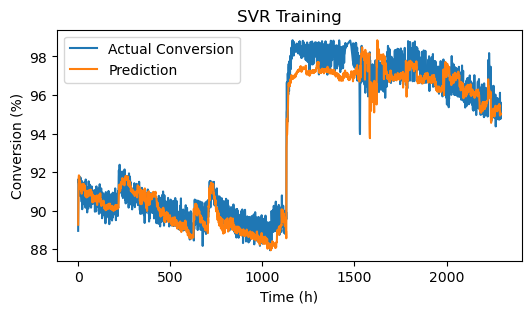

In [126]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_val), label = "Actual Conversion")
    plt.plot(return_conversion_scale(svr_val_pred), label = "Prediction")
    plt.title('SVR Training')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

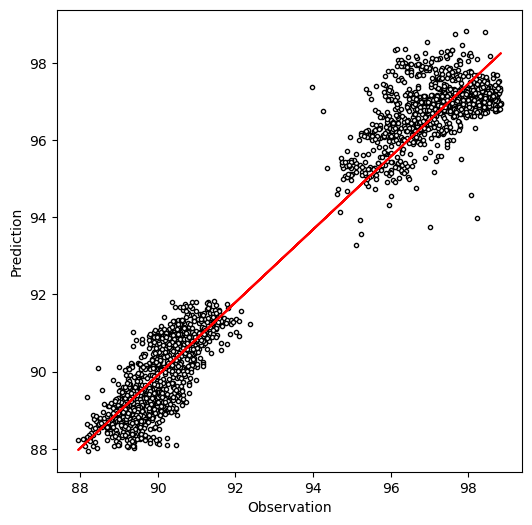

In [127]:
#Plot relationship between observed and predicted value
m_svr_train, b_svr_train = np.polyfit(return_conversion_scale(y_val), return_conversion_scale(svr_val_pred), 1)

with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_val), return_conversion_scale(svr_val_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_val), m_svr_train*(return_conversion_scale(y_val)) + b_svr_train, color = 'r')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [128]:
#Testing the final model 
svr_predict = svr_final.predict(X_test)

In [129]:
#Evaluating final model SVR performance

model_metrics(y_test, svr_predict)

Mean Absolute Error: 1.0179726029235945
Mean Squared Error: 1.5773386333560107
Root Mean Squared Error: 1.255921428018493
Coefficient of Determination: 0.7475925074056085
Akaike Information Criterion: 1.765
Bayesian Information Criterion: 13.358


<Figure size 640x480 with 0 Axes>

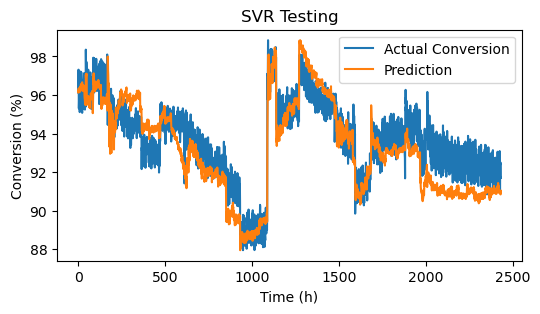

In [130]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_test), label = "Actual Conversion")
    plt.plot(return_conversion_scale(svr_predict), label = "Prediction")
    plt.title('SVR Testing')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

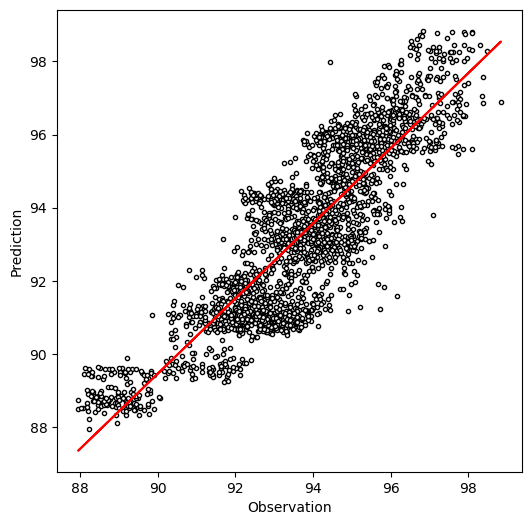

In [131]:
#Plot relationship between observed and predicted value
m_svr_test, b_svr_test = np.polyfit(return_conversion_scale(y_test), return_conversion_scale(svr_predict), 1)
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_test), return_conversion_scale(svr_predict), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_test), m_svr_test*(return_conversion_scale(y_test)) + b_svr_test, color = 'r')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

# RNN - LSTM

In [132]:
#Import RNN-LSTM library
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV

In [133]:
#Reshape data into 3D input
X_train_adj = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])) #reshape (adjust) train shape to 3 dimensional
X_val_adj  = X_val.reshape((X_val.shape[0], 1, X_val.shape[1])) #reshape (adjust) test shape to 3 dimensional
print(X_train_adj.shape, X_val_adj.shape, y_train.shape, y_val.shape )

(11485, 1, 16) (2296, 1, 16) (11485,) (2296,)


In [134]:
#Build the model
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(75, return_sequences = True, input_shape = (X_train_adj.shape[1], X_train_adj.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=30))
model_lstm.add(tf.keras.layers.Dropout(0.2))
model_lstm.add(tf.keras.layers.Dense(units=1))
model_lstm.compile(loss = 'mse', optimizer = 'adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 75)             27600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                12720     
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 40,351
Trainable params: 40,351
Non-trainable params: 0
_________________________________________________________________


In [135]:
#Fit the model
history_lstm = model_lstm.fit(X_train_adj, y_train, epochs = 20, batch_size=64, validation_data = (X_val_adj, y_val), shuffle=False)

Epoch 1/20
180/180 [==============================] - 2s 10ms/step - loss: 0.0495 - val_loss: 0.0430
Epoch 2/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0385 - val_loss: 0.0374
Epoch 3/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0360 - val_loss: 0.0316
Epoch 4/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0331 - val_loss: 0.0270
Epoch 5/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0298 - val_loss: 0.0201
Epoch 6/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0257 - val_loss: 0.0165
Epoch 7/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0221 - val_loss: 0.0156
Epoch 8/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0137
Epoch 9/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0142
Epoch 10/20
180/180 [==============================] - 1s 5ms/step - loss: 0.0183 - val_loss: 0.013

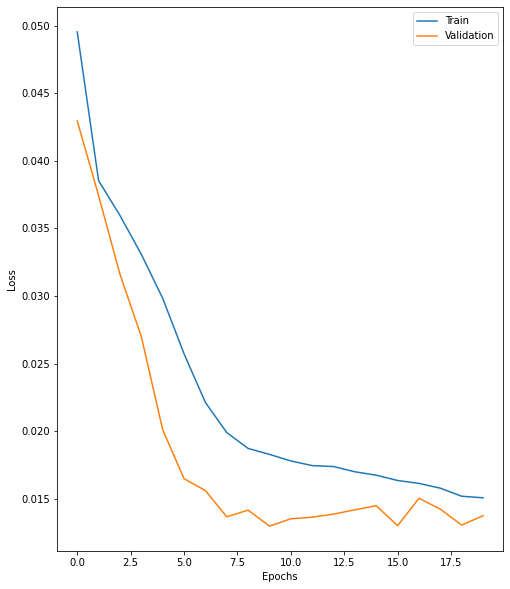

In [136]:
# plot history
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [137]:
lstm_first_pred = model_lstm(X_val_adj)

In [138]:
#Convert Tensor value to array
lstm_first_pred_a = lstm_first_pred.numpy()

In [139]:
model_metrics(y_val, lstm_first_pred_a)

Mean Absolute Error: 1.1176185009376727
Mean Squared Error: 2.441189030944701
Root Mean Squared Error: 1.5624304883561064
Coefficient of Determination: 0.6776607334116627
Akaike Information Criterion: 1515.258
Bayesian Information Criterion: 1526.736


<Figure size 640x480 with 0 Axes>

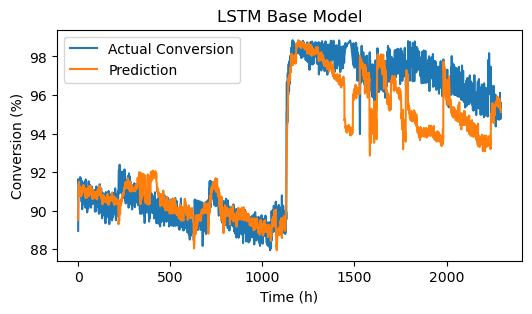

In [140]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_val), label = "Actual Conversion")
    plt.plot(return_conversion_scale(lstm_first_pred), label = "Prediction")
    plt.title('LSTM Base Model')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

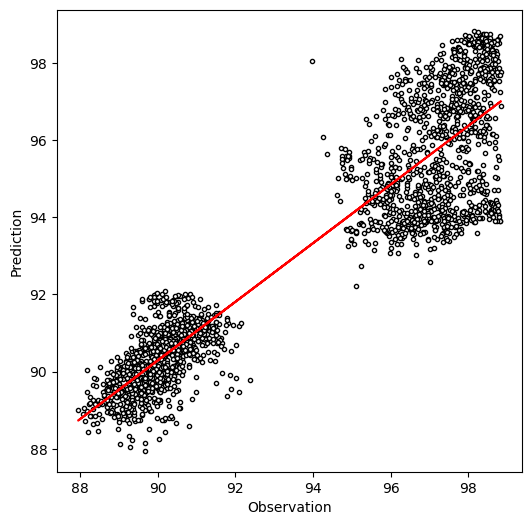

In [141]:
#Plot relationship between observed and predicted value
m_lstm_base, b_lstm_base = np.polyfit(return_conversion_scale(y_val), return_conversion_scale(lstm_first_pred), 1)

with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_val), return_conversion_scale(lstm_first_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_val), m_lstm_base*(return_conversion_scale(y_val)) + b_lstm_base, color = 'r')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [142]:
#LSTM hyperparameter tuning 1st step : batch_size and epochs
#Create LSTM function model
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(75, return_sequences = True, input_shape = (X_train_adj.shape[1], X_train_adj.shape[2])))
    model.add(tf.keras.layers.LSTM(units=30))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=1))
    
    model.compile(loss = 'mse', optimizer = 'adam', metrics=[tf.keras.metrics.MeanSquaredError()])
    model.summary()
    return model

In [ ]:
model_tuning = KerasRegressor(build_fn=create_model, verbose=0)

In [ ]:
# define the grid search parameters
batch_size = [8, 16, 32, 64, 128, 256, 512]
epochs = [10, 15, 20, 50, 100] 

param_grid = dict(batch_size=batch_size, epochs=epochs)
lstm_grid = GridSearchCV(estimator=model_tuning, param_grid=param_grid, n_jobs=-1, cv=ts_split)
grid_result = lstm_grid.fit(X_train_adj, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print(lstm_grid.best_params_)

In [ ]:
#LSTM hyperparameter tuning 2nd step : dropout rate
# fit a model and plot learning curve
def trial_dropout(dropout):
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(75, return_sequences = True, input_shape = (X_train_adj.shape[1], X_train_adj.shape[2])))
    model.add(tf.keras.layers.LSTM(units=30))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units=1))
    
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss = 'mse', optimizer = opt, metrics=[tf.keras.metrics.MeanSquaredError()])
    
    model.summary() 
    
    # fit model
    model_history = model.fit(X_train_adj, y_train, epochs =lstm_grid.best_params_['epochs'], 
                                  batch_size=lstm_grid.best_params_['batch_size'], validation_data = (X_val_adj, y_val), 
                                  verbose=2)
    return(model)

In [ ]:
# run a repeated experiment
def experiment_dropout(n_repeats, dropout):
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        # forecast test dataset
        output = trial_dropout(dropout).predict(X_val_adj)
        # report performance
        mse = metrics.mean_squared_error(y_val, output)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
    return error_scores

In [ ]:
def run_dropout():
    # load dataset
    dropouts = [0.0, 0.1, 0.2, 0.3, 0.4]
    n_repeats = 10
    # run the experiment
    results_dropout = pd.DataFrame()
    for dropout in dropouts:
        results_dropout[str(dropout)] = experiment_dropout(n_repeats, dropout)
    # summarize results
    print(results_dropout.describe())
    # save boxplot
    results_dropout.to_excel('lstm_dropout.xlsx')
    results_dropout.boxplot()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Dropout', fontsize=16)
    plt.ylabel('Mean Squarred Error', fontsize=16)
    plt.savefig('experiment_dropout_input.png')

In [ ]:
run_dropout()

In [ ]:
#LSTM hyperparameter tuning 2nd step : lerning rate
# fit a model and plot learning curve
def trial_lrate(lrate):
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(75, return_sequences = True, input_shape = (X_train_adj.shape[1], X_train_adj.shape[2])))
    model.add(tf.keras.layers.LSTM(units=30))
    model.add(tf.keras.layers.Dropout(0))
    model.add(tf.keras.layers.Dense(units=1))
    
    # compile model
    opt = tf.keras.optimizers.Adam(lr=lrate)
    model.compile(loss = 'mse', optimizer = opt, metrics=[tf.keras.metrics.MeanSquaredError()])
    
    model.summary() 
    
    # fit model
    model_history = model.fit(X_train_adj, y_train, epochs =lstm_grid.best_params_['epochs'], 
                                  batch_size=lstm_grid.best_params_['batch_size'], validation_data = (X_val_adj, y_val), 
                                  verbose=2)
    return(model)

In [ ]:
# run a repeated experiment
def experiment_lrate(n_repeats, lrate):
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        # forecast test dataset
        output = trial_lrate(lrate).predict(X_val_adj)
        # report performance
        mse = metrics.mean_squared_error(y_val, output)
        print('%d) Test RMSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
    return error_scores

In [ ]:
def run_lrate():
    # load dataset
    learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5]
    n_repeats = 10
    # run the experiment
    results = pd.DataFrame()
    for lrate in learning_rates:
        results[str(lrate)] = experiment_lrate(n_repeats, lrate)
    # summarize results
    print(results.describe())
    # save boxplot
    results.to_excel('lstm_lrate.xlsx')
    results.boxplot()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Learning rate', fontsize=16)
    plt.ylabel('Mean Squarred Error', fontsize=16)
    plt.savefig('experiment_dropout_input.png')

In [ ]:
 # entry point
run_lrate()

In [214]:
#Trial learning rate with adjusted epochs. We will use EarlyStopping to halt the iterations if not showing any improvements.
#We can improve the trigger for early stopping by waiting a while before stopping.
#This can be achieved by setting the “patience” argument.

# fit a model and plot learning curve
def tune_lrate(lrate, epochs):
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(75, return_sequences = True, input_shape = (X_train_adj.shape[1], X_train_adj.shape[2])))
    model.add(tf.keras.layers.LSTM(units=30))
    model.add(tf.keras.layers.Dropout(0))
    model.add(tf.keras.layers.Dense(units=1))
    
    # compile model
    opt = tf.keras.optimizers.Adam(lr=lrate)
    model.compile(loss = 'mse', optimizer = opt, metrics=[tf.keras.metrics.MeanSquaredError()])
    
    model.summary() 
    
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
    
    # fit model
    model_history = model.fit(X_train_adj, y_train, epochs =epochs, 
                                  batch_size=128, validation_data = (X_val_adj, y_val), 
                                  verbose=1, callbacks=[es])
   
    # evaluate the model
    _, train_acc = model.evaluate(X_train_adj, y_train, verbose=0)
    _, test_acc = model.evaluate(X_val_adj, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot history
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(model_history.history['loss'], label='train')
    plt.plot(model_history.history['val_loss'], label='test')
    plt.title('lrate='+str(lrate), pad=-50, fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(['Train', 'Validation'], fontsize=12, loc = 'best')
    plt.show()
    return(model)

In [ ]:
#Learning rate 1, epochs 10
lrate_1= tune_lrate(1, 10)

In [ ]:
#Learning rate 0.1, epochs 100
lrate_1= tune_lrate(0.1, 100)

In [ ]:
#Learning rate 0.01, epochs 1000
lrate_1= tune_lrate(0.01, 1000)

In [ ]:
#Learning rate 0.001, epochs 10000
lrate_1= tune_lrate(0.001, 10000)

In [ ]:
#Learning rate 0.0001, epochs 100000
lrate_1= tune_lrate(0.0001, 100000)

In [ ]:
#Learning rate 0.00001, epochs 1000000
lrate_1= tune_lrate(0.00001, 1000000)

In [221]:
#Define final LSTM model
def final_model():
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(75, return_sequences = True, input_shape = (X_train_adj.shape[1], X_train_adj.shape[2])))
    model.add(tf.keras.layers.LSTM(units=30))
    model.add(tf.keras.layers.Dropout(0))
    model.add(tf.keras.layers.Dense(units=1))
    
    # compile model
    opt = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss = 'mse', optimizer = opt, metrics=[tf.keras.metrics.MeanSquaredError()])
    
    model.summary() 
    
    # fit model
    history = model.fit(X_train_adj, y_train, epochs = 110, 
                                  batch_size=128, validation_data = (X_val_adj, y_val), 
                                  verbose=0)
    
    return(model)

In [222]:
#predict taeget for validation
final_pred = final_model().predict(X_val_adj)
model_metrics(y_val, final_pred)

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_118 (LSTM)              (None, 1, 75)             27600     
_________________________________________________________________
lstm_119 (LSTM)              (None, 30)                12720     
_________________________________________________________________
dropout_59 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 31        
Total params: 40,351
Trainable params: 40,351
Non-trainable params: 0
_________________________________________________________________
Mean Absolute Error: 0.4800349428671009
Mean Squared Error: 0.3777357647702033
Root Mean Squared Error: 0.614602119073961
Coefficient of Determination: 0.9689212504390577
Akaike Information Criterion: -2240.962
Bayesian Information Criterion: -222

<Figure size 640x480 with 0 Axes>

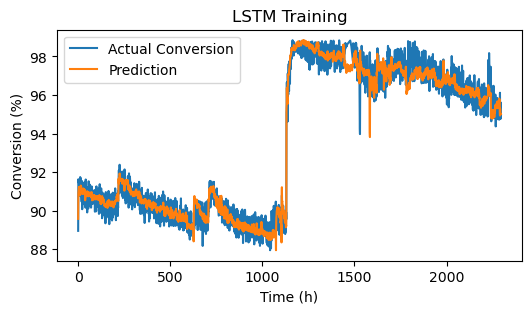

In [223]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_val), label = "Actual Conversion")
    plt.plot(return_conversion_scale(final_pred), label = "Prediction") 
    plt.title('LSTM Training')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

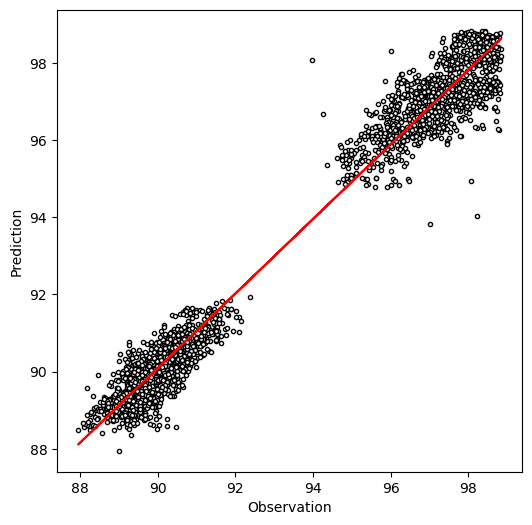

In [224]:
#Plot relationship between observed and predicted value
m_lstm_train, b_lstm_train = np.polyfit(return_conversion_scale(y_val), return_conversion_scale(final_pred), 1)

with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_val), return_conversion_scale(final_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_val), m_lstm_train*(return_conversion_scale(y_val)) + b_lstm_train, color = 'r')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [225]:
#Now predict with test data
#reshape testing data into 3 dimension
X_test_adj = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])) 

#Predict test data
test_pred = final_model().predict(X_test_adj)

#Measure performance metrics
model_metrics(y_test, test_pred)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_120 (LSTM)              (None, 1, 75)             27600     
_________________________________________________________________
lstm_121 (LSTM)              (None, 30)                12720     
_________________________________________________________________
dropout_60 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 31        
Total params: 40,351
Trainable params: 40,351
Non-trainable params: 0
_________________________________________________________________
Mean Absolute Error: 0.6076550150683536
Mean Squared Error: 0.5633083933222952
Root Mean Squared Error: 0.7505387353909825
Coefficient of Determination: 0.8760831284314048
Akaike Information Criterion: -1641.335
Bayesian Information Criterion: -16

<Figure size 640x480 with 0 Axes>

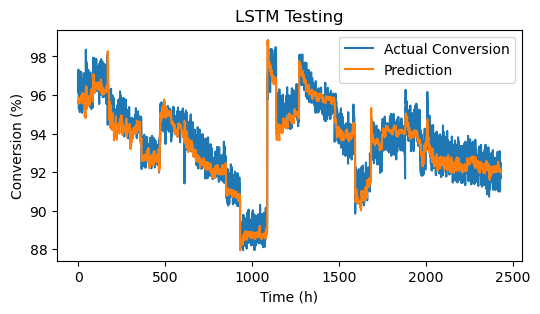

In [226]:
#Plot actual vs prediction
with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,3))
    plt.plot(return_conversion_scale(y_test), label = "Actual Conversion")
    plt.plot(return_conversion_scale(test_pred), label = "Prediction")
    plt.title('LSTM Testing')
    plt.xlabel('Time (h)')
    plt.ylabel('Conversion (%)')
    plt.legend(loc='best')
    plt.show()

<Figure size 640x480 with 0 Axes>

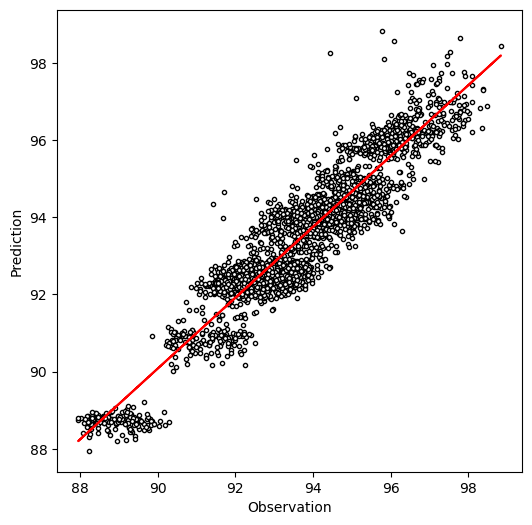

In [227]:
#Plot relationship between observed and predicted value
m_lstm_test, b_lstm_test = np.polyfit(return_conversion_scale(y_test), return_conversion_scale(test_pred), 1)

with plt.style.context('default'):
    plt.figure()
    plt.subplots(figsize=(6,6))
    plt.plot(return_conversion_scale(y_test), return_conversion_scale(test_pred), 'o', 
             markeredgecolor='k', markersize=3, markerfacecolor='w')
    plt.plot(return_conversion_scale(y_test), m_lstm_test*(return_conversion_scale(y_test)) + b_lstm_test, color = 'r')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')
    plt.show()

In [ ]:
# run a repeated experiment
def run_train(n_repeats):
    #Summarize result
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        # forecast test dataset
        output = final_model().predict(X_val_adj)
        # report performance
        score = model_metrics(y_val, output)
        print(score)
        error_scores.append(score)
    return error_scores

In [ ]:
run_train()  # <--- Determine the number of repetition

In [ ]:
# run a repeated experiment
def run_test(n_repeats):
    #Summarize result
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        # forecast test dataset
        predict = final_model().predict(X_test_adj)
        # report performance
        score = model_metrics(y_test, predict)
        print(score)
        error_scores.append(score)
    return error_scores

In [ ]:
run_test() # <--- Determine the number of repetition